In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input
from tensorflow.keras import Model
import sys
sys.path.append("..")   # add parent directory to Python path
import functions
from pathlib import Path
from tensorflow import keras


In [112]:
class autoEncoder:
    def __init__(self, sequence_length, first_layer_dim = 128, second_layer_dim = 32):
        self.sequence_length = sequence_length
        self.first_layer_dim = first_layer_dim
        self.second_layer_dim = second_layer_dim
        self.model = self.build_model()
        self.X_train,self.X_test = self.get_data()
        self.model_is_fitted = False
    def build_model(self):
        self.model = Sequential()

        # Encoder part
        self.model.add(LSTM(self.first_layer_dim, return_sequences=True, input_shape=(self.sequence_length, 1)))
        self.model.add(LSTM(self.second_layer_dim, return_sequences=True))

        # Decoder part  
        self.model.add(LSTM(self.first_layer_dim, return_sequences=True))
        self.model.add(TimeDistributed(Dense(1)))  # Output (batch, time, 1), TimeDistributed helps to handle all dim after second ones
        
        self.model.summary()
        self.model.compile(optimizer='adam', loss='mse')
        return self.model

    def get_data(self, test_sizee=0.2):
        data_lst = []
        scaler = MinMaxScaler(feature_range=(0,1))
        folder = Path("D:\Documents\GitHub\ML_cardiac_prediction\data")
        for p in folder.glob("*.csv"):   # use rglob("*.csv") for subfolders
            voltage = functions.load_voltage(p)
            scaled_voltage = scaler.fit_transform(voltage.reshape(-1, 1))
            data_lst.append(scaled_voltage)
        X = []

        for scaled_voltage in data_lst:
            X.append(scaled_voltage[0:self.sequence_length, 0])

        X = np.array(X)

        X_train, X_test = train_test_split(
            X, test_size=test_sizee, shuffle=False
        )

        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
        return X_train, X_test
    
    def train(self, epochs=30, batch_size=1,save_model=True):
        history = self.model.fit(self.X_train, self.X_train,
                                validation_data=(self.X_test, self.X_test),
                                epochs=epochs, 
                                batch_size=batch_size)
        self.model_is_fitted = True   
        print(self.test())
        if save_model:
            self.model.save(f"AE_seql_{self.sequence_length}_firstL_{self.first_layer_dim}_secondL_{self.second_layer_dim}_epochs_{epochs}.keras")
            
        encoder, decoder = self.get_encoder_decoder()
        return encoder, decoder, history
    def get_encoder_decoder(self):
        if not self.model_is_fitted:
            raise ValueError("Model is not fitted or loaded. Please build or load a model first.")
        encoder = Model(inputs=self.model.layers[0].input,
                        outputs=self.model.layers[1].output)
        # Decoder (create independent input)
        
        latent_input = tf.keras.Input(shape=(self.sequence_length, self.second_layer_dim))
        x = self.model.layers[2](latent_input)
        
        decoder_output = self.model.layers[3](x)
        decoder = Model(inputs=latent_input, outputs=decoder_output)
        return encoder, decoder
    
    def load_model(self, model_path="AE_seql_4500_firstL_128_secondL_32_epochs_60.keras"):
        self.model = keras.models.load_model(model_path)
        self.model_is_fitted = True
        self.first_layer_dim = self.model.layers[0].units
        self.second_layer_dim = self.model.layers[1].units
        self.sequence_length = self.model.input_shape[1]
        return self.model
    
    def test(self):
        if not self.model_is_fitted:
            raise ValueError("Model is not fitted or loaded. Please build or load a model first.")
        X_test_pred = self.model.predict(self.X_test)
        rmse = np.sqrt(mean_squared_error(self.X_test.flatten(), X_test_pred.flatten()))
        print(f"Test Loss: {rmse}")
        return rmse
    
    
    

<>:27: SyntaxWarning: invalid escape sequence '\D'
<>:27: SyntaxWarning: invalid escape sequence '\D'
C:\Users\11061\AppData\Local\Temp\ipykernel_28120\3151649822.py:27: SyntaxWarning: invalid escape sequence '\D'
  folder = Path("D:\Documents\GitHub\ML_cardiac_prediction\data")


In [113]:
model = autoEncoder(4500)

D:\Anaconda\envs\lstm\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_33 (LSTM)                       │ (None, 4500, 128)           │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_34 (LSTM)                       │ (None, 4500, 32)            │          20,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_35 (LSTM)                       │ (None, 4500, 128)           │          82,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_11                  │ (None, 4500, 1)             │             129 │
│ (TimeDistributed)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 169,729 (663.00 KB)

 Trainable params: 169,729 (663.00 KB)

 Non-trainable params: 0 (0.00 B)

In [114]:
model.load_model()

<Sequential name=sequential, built=True>

In [115]:
encoder,decoder = model.get_encoder_decoder()

In [116]:
rmse = model.test()

1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step
Test Loss: 0.006336113544875798


In [100]:
X_train,X_test = model.get_data()

In [101]:
latent = encoder.predict(X_test)
X_test_pred = decoder.predict(latent)
rmse2 = np.sqrt(mean_squared_error(X_test.flatten(), X_test_pred.flatten()))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step


In [102]:
rmse2

np.float64(0.006336113544875798)

In [103]:
encoder,decoder,history = model.train(10) # epochs

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 254s 10s/step - loss: 8.1734e-05 - val_loss: 4.2643e-05
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 128s 8s/step - loss: 7.9869e-05 - val_loss: 4.3763e-05
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 128s 8s/step - loss: 7.6948e-05 - val_loss: 4.2526e-05
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 129s 8s/step - loss: 7.6103e-05 - val_loss: 4.0350e-05
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 129s 8s/step - loss: 7.6378e-05 - val_loss: 4.0877e-05
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 128s 8s/step - loss: 7.7977e-05 - val_loss: 4.0982e-05
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 128s 8s/step - loss: 7.2546e-05 - val_loss: 4.3013e-05
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 127s 8s/step - loss: 7.4947e-05 - val_loss: 3.9896e-05
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 125s 8s/step - loss: 7.9544e-05 - val_loss: 3.7567e-05
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 126s 8s/step - loss: 2.2083e-04 - val_loss: 1.7996e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Test Loss: 0.013415033779650197


Getting latent representations...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 724ms/step
Original X_test shape: (4, 4500, 1)
Latent representations shape: (4, 4500, 32)


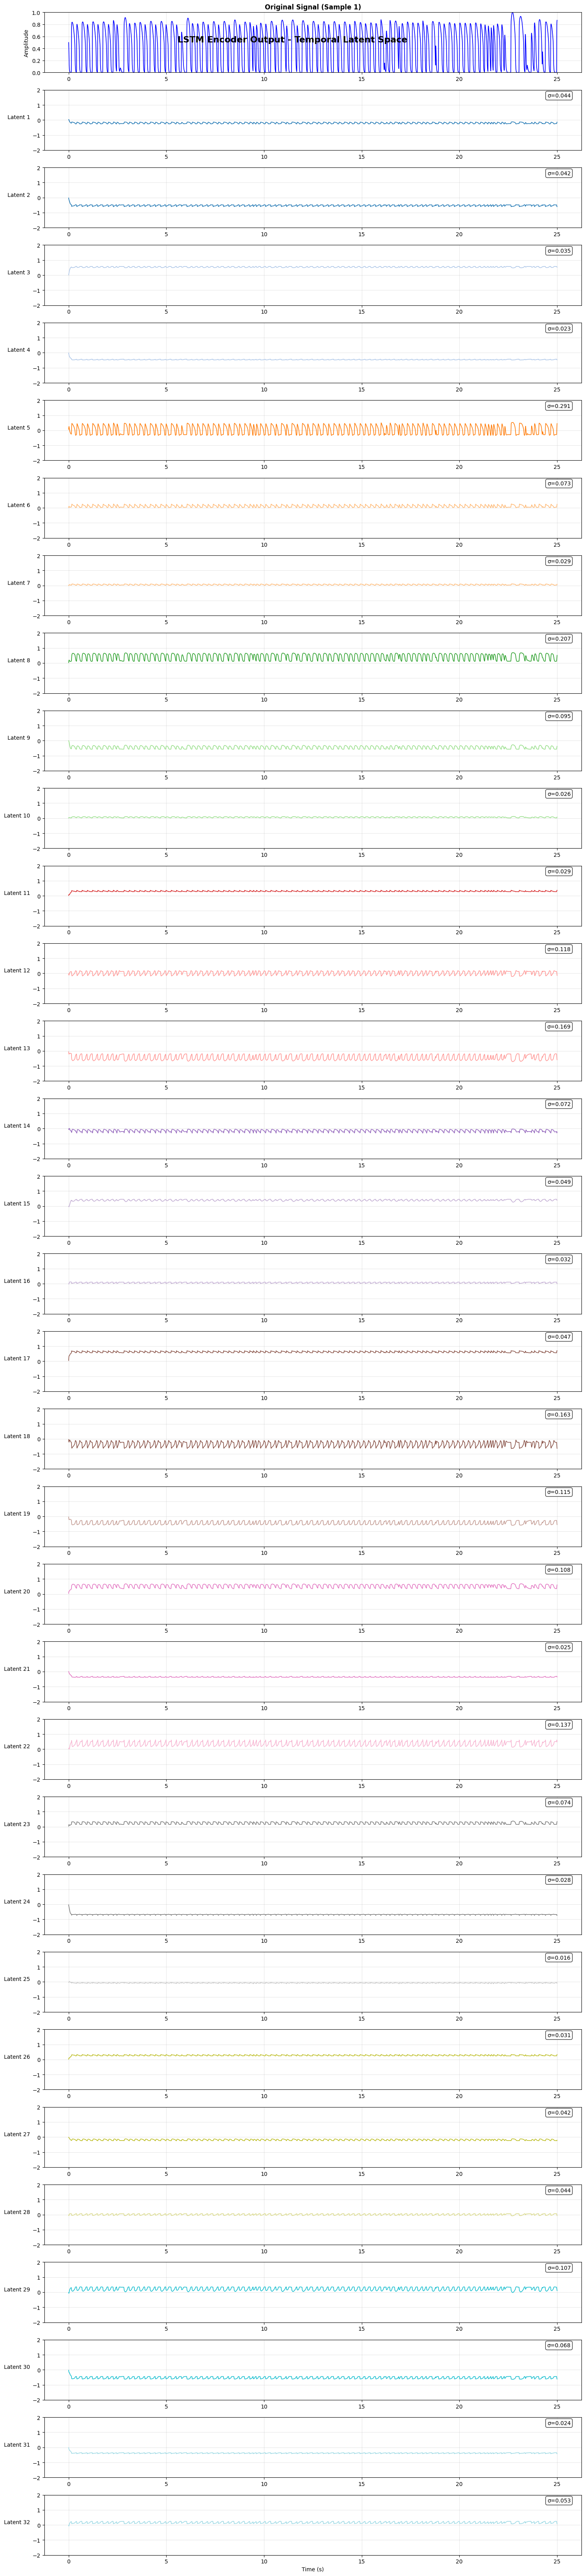

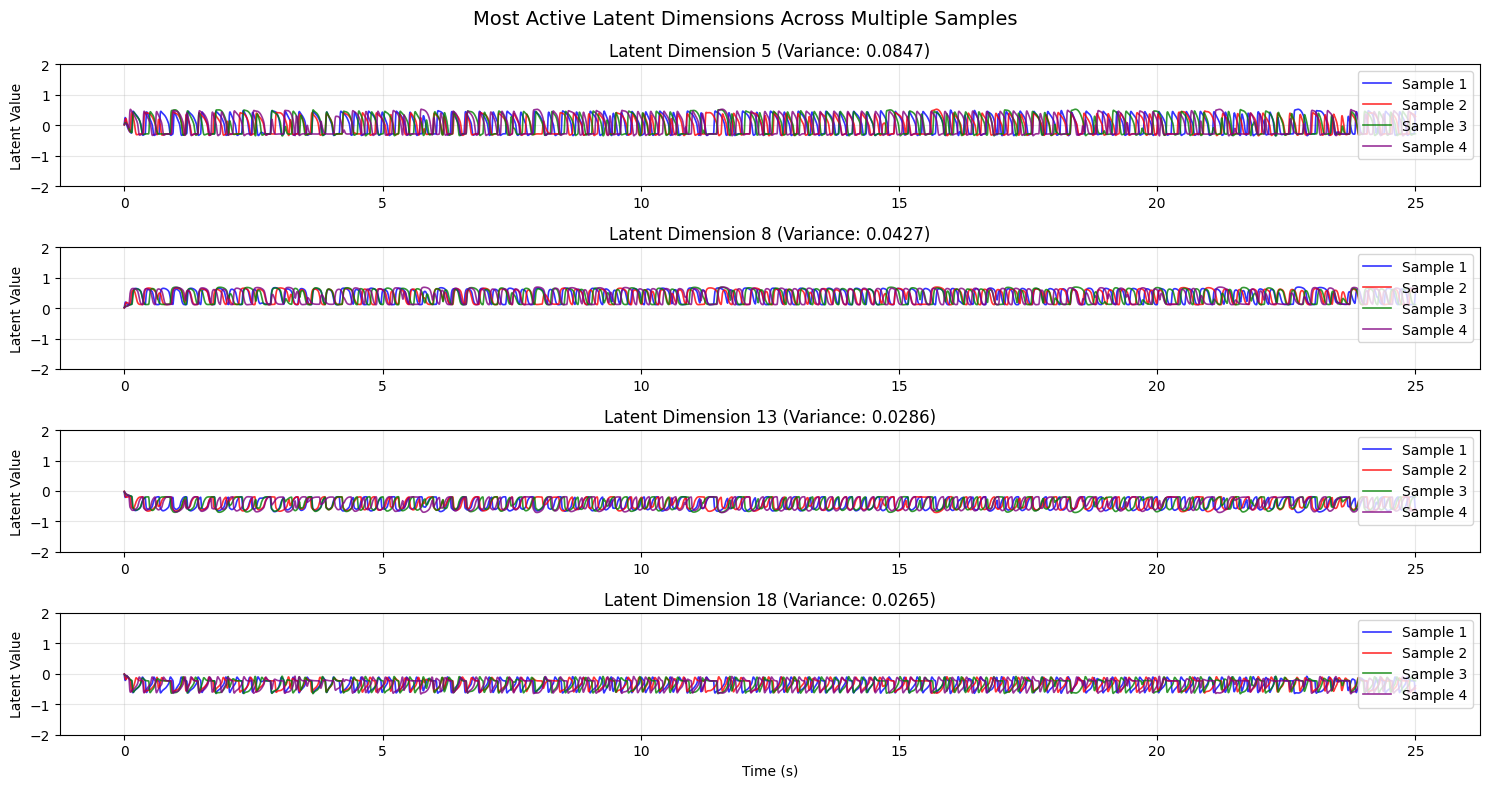


Latent Space Analysis:
Number of latent dimensions: 32
Time steps preserved: 4500
Latent value range: [-0.742, 0.714]
Most active dimension: 5 (variance: 0.0860)
Least active dimension: 25 (variance: 0.0002)


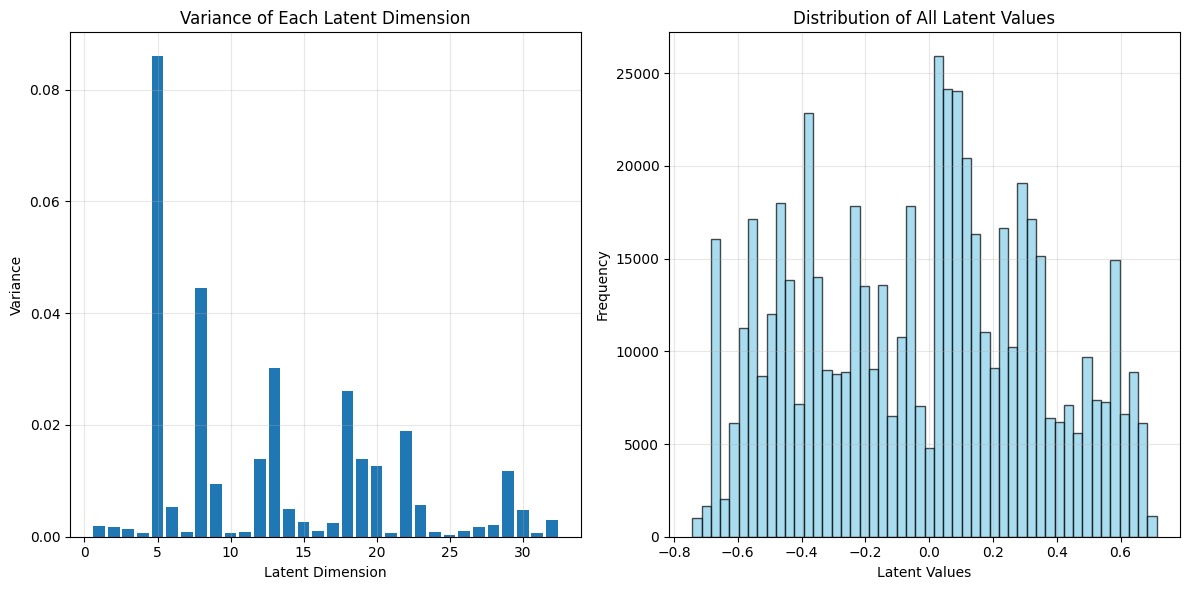


Visualization complete! Your LSTM encoder has converted:
  Input: (4, 4500, 1) → Latent: (4, 4500, 32)
  Each time step now has 32 latent features instead of 1 original feature


In [93]:
import matplotlib.pyplot as plt
import numpy as np

# Get the latent representations from your trained encoder
print("Getting latent representations...")
latent_test = encoder.predict(X_test)
print(f"Original X_test shape: {X_test.shape}")
print(f"Latent representations shape: {latent_test.shape}")

# Create visualization similar to the paper
n_samples = min(5, len(X_test))  # Show first 5 samples
n_latent_dims = latent_test.shape[2]  # Number of latent dimensions
time_steps = latent_test.shape[1]

# Create time axis (adjust based on your actual time scale)
time_axis = np.linspace(0, 25, time_steps)  # Assuming 25 seconds total

# Create the main plot
fig, axes = plt.subplots(n_latent_dims + 1, 1, figsize=(15, 2 * (n_latent_dims + 1)))
fig.suptitle('LSTM Encoder Output - Temporal Latent Space', fontsize=16, fontweight='bold')

# Plot original signal for reference (first sample)
axes[0].plot(time_axis, X_test[0].flatten(), 'b-', linewidth=1.2)
axes[0].set_title('Original Signal (Sample 1)', fontweight='bold')
axes[0].set_ylabel('Amplitude')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([X_test.min(), X_test.max()])

# Plot each latent dimension
colors = plt.cm.tab20(np.linspace(0, 1, n_latent_dims))  # Different colors for each dimension

for i in range(n_latent_dims):
    # Plot the first sample's latent dimension
    axes[i+1].plot(time_axis, latent_test[0, :, i], 
                   color=colors[i], linewidth=1.2)
    axes[i+1].set_ylabel(f'Latent {i+1}', rotation=0, ha='right')
    axes[i+1].grid(True, alpha=0.3)
    
    # Set consistent y-axis range for latent dimensions
    axes[i+1].set_ylim([-2, 2])  # Adjust based on your latent range
    
    # Add magnitude annotation
    magnitude = np.std(latent_test[0, :, i])
    axes[i+1].text(0.98, 0.95, f'σ={magnitude:.3f}', 
                   transform=axes[i+1].transAxes, 
                   ha='right', va='top',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

axes[-1].set_xlabel('Time (s)')
plt.tight_layout()
plt.show()

# Additional analysis: Show multiple samples for comparison
if len(X_test) > 1:
    fig, axes = plt.subplots(min(4, n_latent_dims), 1, figsize=(15, 8))
    if min(4, n_latent_dims) == 1:
        axes = [axes]
    
    # Show first 4 most active latent dimensions across multiple samples
    latent_vars = np.var(latent_test[0], axis=0)  # Variance of each dimension
    most_active = np.argsort(latent_vars)[-4:][::-1]  # Top 4 most varying dimensions
    
    sample_colors = ['blue', 'red', 'green', 'purple', 'orange']
    
    for i, dim_idx in enumerate(most_active):
        if i >= len(axes):
            break
            
        for sample_idx in range(min(n_samples, len(sample_colors))):
            axes[i].plot(time_axis, latent_test[sample_idx, :, dim_idx], 
                        color=sample_colors[sample_idx], 
                        alpha=0.8, linewidth=1.2,
                        label=f'Sample {sample_idx+1}')
        
        axes[i].set_title(f'Latent Dimension {dim_idx+1} (Variance: {latent_vars[dim_idx]:.4f})')
        axes[i].set_ylabel('Latent Value')
        axes[i].grid(True, alpha=0.3)
        axes[i].legend()
        axes[i].set_ylim([-2, 2])
    
    axes[-1].set_xlabel('Time (s)')
    plt.suptitle('Most Active Latent Dimensions Across Multiple Samples', fontsize=14)
    plt.tight_layout()
    plt.show()

# Statistical summary
print("\nLatent Space Analysis:")
print(f"Number of latent dimensions: {n_latent_dims}")
print(f"Time steps preserved: {time_steps}")
print(f"Latent value range: [{latent_test.min():.3f}, {latent_test.max():.3f}]")

# Find most and least active dimensions
latent_vars = np.var(latent_test.reshape(-1, n_latent_dims), axis=0)
most_active_dim = np.argmax(latent_vars)
least_active_dim = np.argmin(latent_vars)

print(f"Most active dimension: {most_active_dim+1} (variance: {latent_vars[most_active_dim]:.4f})")
print(f"Least active dimension: {least_active_dim+1} (variance: {latent_vars[least_active_dim]:.4f})")

# Show variance of all dimensions
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(range(1, n_latent_dims+1), latent_vars)
plt.xlabel('Latent Dimension')
plt.ylabel('Variance')
plt.title('Variance of Each Latent Dimension')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Show distribution of latent values
plt.hist(latent_test.flatten(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Latent Values')
plt.ylabel('Frequency')
plt.title('Distribution of All Latent Values')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nVisualization complete! Your LSTM encoder has converted:")
print(f"  Input: {X_test.shape} → Latent: {latent_test.shape}")
print(f"  Each time step now has {n_latent_dims} latent features instead of 1 original feature")